<a href="https://colab.research.google.com/github/SARANG1018/LORA_Lords/blob/main/LORA_Lords_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Name: LORA_Lords

# Team Members

Sarang Pinakin Kadakia (sk11634)

Rujuta Amit Joshi (vk2630)

Vishwajeet Swapnil Kulkarni (rj2719)


Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
! pip install optuna # U

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached trl-0.16.1-py3-none-any.whl.metadata (12 kB)
  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
Using cached trl-0.16.1-py3-none-any.whl (336 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
Using cached multiprocess-0.70.16-py311-none-any.whl (143 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl 

In [ ]:
! pip install hf_xet

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification, BitsAndBytesConfig, EarlyStoppingCallback # U
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from optuna.trial import Trial

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # loading the model weights in 4-bit precision
    bnb_4bit_use_double_quant= True, # using double quantization for 4-bit weights
    # nf4: non-uniform quantization scheme (a form of adaptive quantization) that tends to capture a wider range of weights more effectively!
    bnb_4bit_quant_type = "nf4", # using nf4 quantization type for 4-bit weights, another opt I know id fp4!
    bnb_4bit_compute_dtype= torch.bfloat16, # performing computations in bfloat16 format
    llm_int8_skip_modules= ["classifier"]
)

## Load Tokenizer and Preprocess Data

In [ ]:
dataset = load_dataset('ag_news', split = 'train')
dataset[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
base_model = 'roberta-base'

tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
  # examples['text'] access the text content (text from the 'text' column) within current batch of examples
  # truncation = True: Ensures consistent input sizes
  # padding = True: pad tokens with special tokens to match the longest sequence in the batch
  tokenized = tokenizer(examples['text'], truncation = True, padding = True)
  return tokenized

tokenized_dataset = dataset.map(preprocess, batched = True, remove_columns = ['text']) # remove_columns = ['text']: this is a good practice as we would not need original 'text' column after tokenization!
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels') # HuggingFace works well with 'labels' as a feature-name!

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# print(dataset[0])
print(len(dataset))
print(len(tokenized_dataset))

120000
120000


In [ ]:
# Extracting the number of classes and their names
num_labels = dataset.features['label'].num_classes # number of labels
class_names = dataset.features['label'].names # name of the corresponding classes
print(f"number of classes: {num_labels}")
print(f"label names: {class_names}")

# Creatig id2label mapping, needing for our classifier
id2label = {i: label for i, label in enumerate(class_names)}

# This pads each batch to the maximum length (within that batch) significantly reducing computational overhead and memory usage.
datacollator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of classes: 4
label names: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
base = RobertaForSequenceClassification.from_pretrained(
    base_model, id2label = id2label
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Anything from here on can be modified

In [ ]:
# Splitting the original training set
split_datasets = tokenized_dataset.train_test_split(test_size = 640, seed = 42, stratify_by_column = 'labels') # (U)
train_set = split_datasets['train']
train_set = train_set.shuffle(seed = 42) # U
test_set = split_datasets['test']
test_set = test_set.shuffle(seed = 42) # U

# print(len(train_set))
# print(len(test_set))

# print(train_set[0])

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# Static code
# Peft Config (PEFT: Parameter Efficient Fine-Tuning!)
static_peft = LoraConfig(
    r = 10, # rank of updated matrices! (U)
    lora_alpha = 64, # scaling factor for learned updates controlling the strength of LORA adaption (U)
    lora_dropout = 0.1, # prob for the dropping LORA layers (helps in regularization)
    bias = 'none', # specifies if we want to apply bias to LORA updates
    target_modules = ['query', 'value'], # specifies which target modules do I need to apply LORA to, in our case (query and value modules of the pre-trained RobertaModel!)
    task_type = "SEQ_CLS", # determines what type of task are we performing and acc applies LORA!
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
static_model = get_peft_model(base, static_peft).to(device)
static_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [ ]:
# Determining the number of trainable parameters within the peft_model!
print("Trainable parameters:")
for name, param in static_model.named_parameters(): # named_parameters(): It is an iterator, a method in pytorch, yielding the name and parameter tensor for each parameter in the model
  if param.requires_grad: # requires_grad: boolean value (only the parameters that need to be updated during fine-tuning will have `requires_grad=True`.  All other parameters of the pre-trained model will be frozen (i.e., their values won't change).
    print(name)
    # print(len(param))

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.sel

In [ ]:
print('PEFT Model!')
static_model.print_trainable_parameters() # will print the total number of trainable parameters!

PEFT Model!
trainable params: 962,308 || all params: 125,611,016 || trainable%: 0.7661


## Training Setup

In [ ]:
# This will track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1) # will contain output probabilities of each class and argmax(-1) will help find out max val over each determining the class which it belongs to!
  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="weighted")
  recall = recall_score(labels, preds, average = "weighted")
  f1 = f1_score(labels, preds, average="weighted")
  return {
      'accuracy' : accuracy,
      'precision' : precision,
      'recall' : recall,
      'f1' : f1
  }

In [ ]:
# Setup Training args

training_args = TrainingArguments(
    output_dir="hpo_results",
    max_steps=200,  # Shorter trials
    eval_steps=50,
    per_device_train_batch_size=32,  # Larger batches
    fp16=True,  # Use mixed precision
    dataloader_num_workers=4,
    report_to=None,
    metric_for_best_model="eval_accuracy",
    eval_strategy = "steps",
    greater_is_better=True
)


# Hyperparameter Fine-tuning using HyperOpt

In [ ]:
from optuna.pruners import MedianPruner

In [ ]:
# Initializing the model hyperparam-tuning fucntion
def model_init(trial: Trial = None):
      if trial is None:
        return static_model

      base = RobertaForSequenceClassification.from_pretrained(
          base_model, id2label = id2label
      )

      peft_config = LoraConfig(
        r = 10,
        lora_alpha = 64,
        lora_dropout = 0.1,
        bias = "none",
        target_modules= ["query", "value"],
        task_type = "SEQ_CLS"
      )
      peft_model = get_peft_model(base, peft_config).to(device)
      return peft_model

In [ ]:
# Taking small subset of data for performing hyperparameter fine-tuning!
small_dataset = tokenized_dataset.train_test_split(train_size = 0.1, test_size = 0.05, seed = 42, stratify_by_column = "labels")
small_train_set = small_dataset["train"]
small_test_set = small_dataset["test"]

In [ ]:
print(f"Small set training examples: {len(small_train_set)}")
print(f"Small set testing examples: {len(small_test_set)}")

Small set training examples: 12000
Small set testing examples: 6000


In [ ]:
trainer = Trainer(
      # model = peft_model,
      model_init = model_init,
      args = training_args,
      compute_metrics = compute_metrics,
      train_dataset= small_train_set,
      eval_dataset= small_test_set,
      data_collator = datacollator,
      callbacks = [EarlyStoppingCallback(early_stopping_patience= 3)]
  )

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
best_run = trainer.hyperparameter_search(
    direction = "maximize", # maximize eval_acc
    backend = "optuna",
    n_trials = 20,
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=100),
    hp_space = lambda trial:{
        "learning_rate":               trial.suggest_loguniform("learning_rate", 1e-5, 5e-4),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "gradient_accumulation_steps": trial.suggest_categorical("grad_accum", [1, 2, 4]),
        "weight_decay":                trial.suggest_categorical("weight_decay", [0.0, 0.01])
    },
)

print("Best hyperparameters:", best_run.hyperparameters)

[I 2025-04-20 23:11:44,847] A new study created in memory with name: no-name-02e03278-3d4c-44d2-acc2-4b7b8b0c02f5
<ipython-input-39-1b393aa0926a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":               trial.suggest_loguniform("learning_rate", 1e-5, 5e-4),
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.115334,0.872667,0.872280,0.872667,0.872328
100,No log,0.348327,0.885500,0.884948,0.885500,0.884807
150,No log,0.309951,0.898833,0.898655,0.898833,0.898628
200,No log,0.302057,0.900000,0.899767,0.900000,0.899813


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▄██
eval/f1,▁▄██
eval/loss,█▁▁▁
eval/precision,▁▄██
eval/recall,▁▄██
eval/runtime,█▇▁▄
eval/samples_per_second,▁▂█▅
eval/steps_per_second,▁▂█▅
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.9


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.314981,0.568333,0.765381,0.568333,0.507095
100,No log,0.454674,0.881667,0.883386,0.881667,0.881722
150,No log,0.341624,0.894833,0.895054,0.894833,0.894796
200,No log,0.330209,0.892667,0.892033,0.892667,0.892287


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/precision,▁▇██
eval/recall,▁███
eval/runtime,█▁▅▇
eval/samples_per_second,▁█▄▂
eval/steps_per_second,▁█▄▂
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.89267


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.371739,0.888833,0.888330,0.888833,0.888111
100,No log,0.303028,0.899833,0.899668,0.899833,0.899678
150,No log,0.301411,0.901000,0.903077,0.901000,0.901008
200,No log,0.289656,0.902667,0.905698,0.902667,0.902306


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▇▇█
eval/f1,▁▇▇█
eval/loss,█▂▂▁
eval/precision,▁▆▇█
eval/recall,▁▇▇█
eval/runtime,▂█▃▁
eval/samples_per_second,▇▁▆█
eval/steps_per_second,▇▁▆█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.90267


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.384792,0.297000,0.207606,0.297000,0.184080
100,No log,1.379840,0.303667,0.239020,0.303667,0.190995
150,No log,1.376016,0.276167,0.296774,0.276167,0.149989
200,No log,1.374573,0.341833,0.266484,0.341833,0.237347


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

eval/accuracy,▃▄▁█
eval/f1,▄▄▁█
eval/loss,█▅▂▁
eval/precision,▁▃█▆
eval/recall,▃▄▁█
eval/runtime,█▃▂▁
eval/samples_per_second,▁▆▇█
eval/steps_per_second,▁▆▇█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.34183


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.393387,0.882833,0.884043,0.882833,0.883282
100,No log,0.302866,0.899667,0.900881,0.899667,0.899574
150,No log,0.288035,0.903833,0.904266,0.903833,0.903707
200,No log,0.284352,0.906833,0.907315,0.906833,0.906731


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▆▇█
eval/f1,▁▆▇█
eval/loss,█▂▁▁
eval/precision,▁▆▇█
eval/recall,▁▆▇█
eval/runtime,█▃▂▁
eval/samples_per_second,▁▆▇█
eval/steps_per_second,▁▆▇█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.90683


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.457404,0.887833,0.887833,0.887833,0.887667
100,No log,0.302784,0.900500,0.900662,0.900500,0.900291
150,No log,0.289799,0.905500,0.906002,0.905500,0.905476
200,No log,0.285645,0.906667,0.906416,0.906667,0.906497


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▆██
eval/f1,▁▆██
eval/loss,█▂▁▁
eval/precision,▁▆██
eval/recall,▁▆██
eval/runtime,█▂▆▁
eval/samples_per_second,▁▇▃█
eval/steps_per_second,▁▇▃█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.90667


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.305761,0.899000,0.900581,0.899000,0.899110
100,No log,0.274146,0.907833,0.908103,0.907833,0.907653
150,No log,0.267183,0.912333,0.912528,0.912333,0.912292
200,No log,0.266690,0.911500,0.913056,0.911500,0.911291


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▆██
eval/f1,▁▆█▇
eval/loss,█▂▁▁
eval/precision,▁▅██
eval/recall,▁▆██
eval/runtime,▂▁█▅
eval/samples_per_second,▇█▁▄
eval/steps_per_second,▇█▁▄
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.9115


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.327094,0.893333,0.896105,0.893333,0.893563
100,No log,0.286069,0.901333,0.902687,0.901333,0.901223
150,No log,0.270815,0.909333,0.909907,0.909333,0.909342
200,No log,0.269333,0.908500,0.909279,0.908500,0.908467


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▅██
eval/f1,▁▄██
eval/loss,█▃▁▁
eval/precision,▁▄██
eval/recall,▁▅██
eval/runtime,▁▅█▇
eval/samples_per_second,█▄▁▂
eval/steps_per_second,█▄▁▂
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.9085


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.371402,0.492167,0.674238,0.492167,0.439635
100,No log,1.338408,0.792333,0.807584,0.792333,0.788760


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-04-20 23:45:31,514] Trial 8 pruned. 
<ipython-input-39-1b393aa0926a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":               trial.suggest_loguniform("learning_rate", 1e-5, 5e-4),
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classi

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.79233


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.378967,0.306833,0.248473,0.306833,0.196024
100,No log,1.364675,0.318500,0.801814,0.318500,0.213899


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-04-20 23:47:17,955] Trial 9 pruned. 
<ipython-input-39-1b393aa0926a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.3185


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.302932,0.900667,0.903641,0.900667,0.900826
100,No log,0.272636,0.907333,0.908670,0.907333,0.907136
150,No log,0.258853,0.912833,0.913986,0.912833,0.912691
200,No log,0.261783,0.911333,0.912939,0.911333,0.911117


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▅█▇
eval/f1,▁▅█▇
eval/loss,█▃▁▁
eval/precision,▁▄█▇
eval/recall,▁▅█▇
eval/runtime,▁▁██
eval/samples_per_second,██▁▁
eval/steps_per_second,██▁▁
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.91133


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.298729,0.903667,0.906081,0.903667,0.903898
100,No log,0.270793,0.907333,0.908233,0.907333,0.907279
150,No log,0.263253,0.911500,0.912123,0.911500,0.911404
200,No log,0.264530,0.911500,0.913305,0.911500,0.911304


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▄██
eval/f1,▁▄██
eval/loss,█▂▁▁
eval/precision,▁▃▇█
eval/recall,▁▄██
eval/runtime,▂▁▇█
eval/samples_per_second,▇█▂▁
eval/steps_per_second,▇█▂▁
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.9115


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.322075,0.897167,0.898423,0.897167,0.897325
100,No log,0.288798,0.900667,0.902260,0.900667,0.900366
150,No log,0.270433,0.910833,0.911217,0.910833,0.910863
200,No log,0.269992,0.909333,0.910258,0.909333,0.909186


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▃█▇
eval/f1,▁▃█▇
eval/loss,█▄▁▁
eval/precision,▁▃█▇
eval/recall,▁▃█▇
eval/runtime,█▃█▁
eval/samples_per_second,▁▆▁█
eval/steps_per_second,▁▆▁█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.90933


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.332699,0.892167,0.895414,0.892167,0.892102
100,No log,0.287026,0.902500,0.904626,0.902500,0.902238
150,No log,0.267962,0.912167,0.912726,0.912167,0.912168
200,No log,0.267202,0.909667,0.910892,0.909667,0.909509


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▅█▇
eval/f1,▁▅█▇
eval/loss,█▃▁▁
eval/precision,▁▅█▇
eval/recall,▁▅█▇
eval/runtime,█▂▁▃
eval/samples_per_second,▁▇█▆
eval/steps_per_second,▁▇█▆
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.90967


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.365796,0.884000,0.888134,0.884000,0.884303
100,No log,0.292963,0.903167,0.903801,0.903167,0.903060
150,No log,0.279270,0.907500,0.907863,0.907500,0.907489
200,No log,0.276600,0.906667,0.906768,0.906667,0.906543


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▂▁▁
eval/precision,▁▇██
eval/recall,▁▇██
eval/runtime,▇▁▆█
eval/samples_per_second,▂█▃▁
eval/steps_per_second,▂█▃▁
train/epoch,▁▃▆█
train/global_step,▁▃▆█
eval/accuracy,0.90667


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,1.328938,0.763833,0.828843,0.763833,0.754823
100,No log,0.669559,0.880333,0.879841,0.880333,0.879751


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-04-21 00:07:16,226] Trial 15 pruned. 
<ipython-input-39-1b393aa0926a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":               trial.suggest_loguniform("learning_rate", 1e-5, 5e-4),
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'class

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.88033


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.375485,0.890833,0.891853,0.890833,0.890496
100,No log,0.304596,0.896000,0.896274,0.896000,0.895452


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-04-21 00:08:42,945] Trial 16 pruned. 
<ipython-input-39-1b393aa0926a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate":               trial.suggest_loguniform("learning_rate", 1e-5, 5e-4),
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'class

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.896


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.326755,0.896167,0.897448,0.896167,0.896466
100,No log,0.294108,0.903167,0.904696,0.903167,0.903032
150,No log,0.273956,0.911333,0.911777,0.911333,0.911369
200,No log,0.272361,0.910667,0.910621,0.910667,0.910534


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▄██
eval/f1,▁▄██
eval/loss,█▄▁▁
eval/precision,▁▅█▇
eval/recall,▁▄██
eval/runtime,▅▃█▁
eval/samples_per_second,▄▆▁█
eval/steps_per_second,▄▆▁█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.91067


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.289650,0.906333,0.907388,0.906333,0.906180
100,No log,0.267820,0.908000,0.907748,0.908000,0.907848
150,No log,0.256940,0.914500,0.915288,0.914500,0.914447
200,No log,0.250954,0.914000,0.913981,0.914000,0.913791


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

eval/accuracy,▁▂██
eval/f1,▁▂█▇
eval/loss,█▄▂▁
eval/precision,▁▁█▇
eval/recall,▁▂██
eval/runtime,▁█▂█
eval/samples_per_second,█▁▇▁
eval/steps_per_second,█▁▇▁
train/epoch,▁▃▆██
train/global_step,▁▃▆██
eval/accuracy,0.914


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.543220,0.879167,0.878712,0.879167,0.878637
100,No log,0.309654,0.901167,0.901119,0.901167,0.900986


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2025-04-21 00:18:51,453] Trial 19 pruned. 


Best hyperparameters: {'learning_rate': 0.000323000557918686, 'batch_size': 32, 'grad_accum': 2, 'weight_decay': 0.01}


In [ ]:
# This is imp for printing training steps
from transformers import TrainerCallback

class TrainMetricsCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        self.trainer = kwargs.get("trainer", None)

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Skip if trainer or train_dataset is not available
        if self.trainer is None or not hasattr(self.trainer, "train_dataset"):
            return

        # Evaluate on a small subset of training data
        small_train_subset = self.trainer.train_dataset.select(range(256))  # or use random.shuffle
        preds = self.trainer.predict(small_train_subset)

        labels = preds.label_ids
        predictions = preds.predictions.argmax(axis=-1)
        train_acc = accuracy_score(labels, predictions)

        logs["train_accuracy"] = train_acc
        print(f"[Train Accuracy] Step {state.global_step}: {train_acc:.4f}")

In [ ]:
best = best_run.hyperparameters
print(best)

# statically inserting for now (only tweaked num_epochs so!)
final_peft = LoraConfig(
    r = 10, # rank of updated matrices! (U)
    lora_alpha = 64, # scaling factor for learned updates controlling the strength of LORA adaption (U)
    lora_dropout = 0.1, # prob for the dropping LORA layers (helps in regularization)
    bias = "none", # specifies if we want to apply bias to LORA updates
    target_modules = ["query","value"],  # specifies which target modules do I need to apply LORA to, in our case (query and value modules of the pre-trained RobertaModel!)
    task_type = "SEQ_CLS", # determines what type of task are we performing and acc applies LORA!
)

# Reloading the base (the backbone never changes, we will fine‑tune on top of it)
final_base = RobertaForSequenceClassification.from_pretrained(
    # "roberta-base", id2label=id2label, quantization_config=quantization_config
    "roberta-base", id2label=id2label
)

final_model = get_peft_model(final_base, final_peft).to(device)

# Finally, rebuilding my TrainingArguments from the best values after hyperparameter fine-tuning!
output_dir = "result"
final_training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate = best["learning_rate"],
    per_device_train_batch_size = best["batch_size"],
    gradient_accumulation_steps = best["grad_accum"],
    weight_decay=best["weight_decay"],
    report_to=None,
    eval_strategy='steps',
    logging_steps=50,
    num_train_epochs=1,
    lr_scheduler_type='cosine_with_restarts',
    max_steps=2000,
    warmup_ratio=0.1,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_eval_batch_size=64,
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True},
    eval_steps=400,
    fp16=True,
    optim = "adamw_torch",
    # bf16=True,
    save_strategy="steps",
    save_steps=400,
    save_total_limit=2,
    label_names=["labels"], # U
    load_best_model_at_end= True, # U
    metric_for_best_model= "eval_accuracy", # U
    greater_is_better= True, # U
)

final_trainer = Trainer(
    model = final_model,
    args = final_training_args,
    compute_metrics= compute_metrics,
    train_dataset= train_set,
    eval_dataset= test_set,
    data_collator = datacollator,
    callbacks = [
        EarlyStoppingCallback(early_stopping_patience= 3),
        TrainMetricsCallback()
        ]
)

{'learning_rate': 0.000323000557918686, 'batch_size': 32, 'grad_accum': 2, 'weight_decay': 0.01}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Start Training

In [ ]:
result = final_trainer.train()
print(result)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
400,0.265600,0.273508,0.912500,0.912564,0.912500,0.912225
800,0.212900,0.212321,0.921875,0.921658,0.921875,0.921417
1200,0.200200,0.215362,0.926562,0.926769,0.926562,0.926122
1600,0.173300,0.201267,0.928125,0.927942,0.928125,0.927887
2000,0.176100,0.199619,0.932813,0.932531,0.932813,0.932585


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

TrainOutput(global_step=2000, training_loss=0.25502265501022336, metrics={'train_runtime': 1628.1421, 'train_samples_per_second': 78.617, 'train_steps_per_second': 1.228, 'total_flos': 2.258345883631411e+16, 'train_loss': 0.25502265501022336, 'epoch': 1.0723860589812333})


## Evaluate Finetuned Model


### Performing Inference on Custom Input


In [ ]:
def classify(model, tokenizer, text):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  inputs = tokenizer(text, truncation = True, padding = True, return_tensors = "pt").to(device)
  output = model(**inputs)

  prediction = output.logits.argmax(dim = -1).item()

  print(f"\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}")
  return id2label[prediction]

In [ ]:
classify(final_trainer.model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify(final_trainer.model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Checking evaluation accuracy
metrics, _ = evaluate_model(final_trainer.model, test_set, labelled=True, batch_size=32, data_collator=datacollator)
print("Final test accuracy:", metrics["accuracy"])

100%|██████████| 20/20 [00:03<00:00,  6.27it/s]

Evaluation Metric: {'accuracy': 0.9328125}
Final test accuracy: 0.9328125


In [ ]:
# Checking train accuracy
train_metrics, _ = evaluate_model(final_trainer.model, train_set, labelled=True, batch_size=32, data_collator=datacollator)

100%|██████████| 3730/3730 [10:00<00:00,  6.21it/s]


Evaluation Metric: {'accuracy': 0.9451323726541555}


In [ ]:
print("Train Accuracy (overall):", train_metrics["accuracy"])

Train Accuracy (overall): 0.9451323726541555


### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
test_dataset = test_dataset.with_format("torch")  # Ensure no shuffle
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
preds = evaluate_model(final_trainer.model, test_dataset, False, 8, datacollator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output_trial9.csv"), index=False)
print("Inference complete. Predictions saved to inference_output_trial9.csv")

100%|██████████| 1000/1000 [00:30<00:00, 32.98it/s]

Inference complete. Predictions saved to inference_output_trial9.csv


# Visualizing our results

100%|██████████| 3730/3730 [09:56<00:00,  6.26it/s]


Evaluation Metric: {'accuracy': 0.9451323726541555}


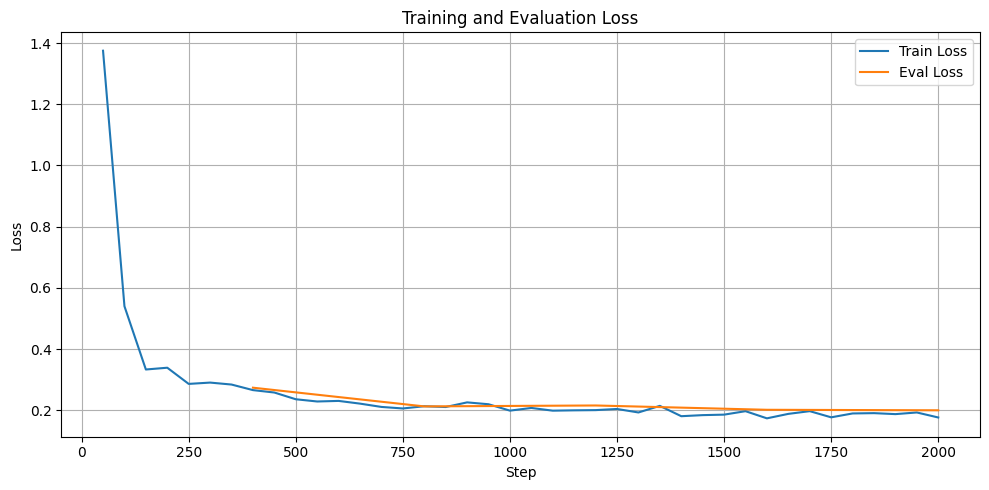

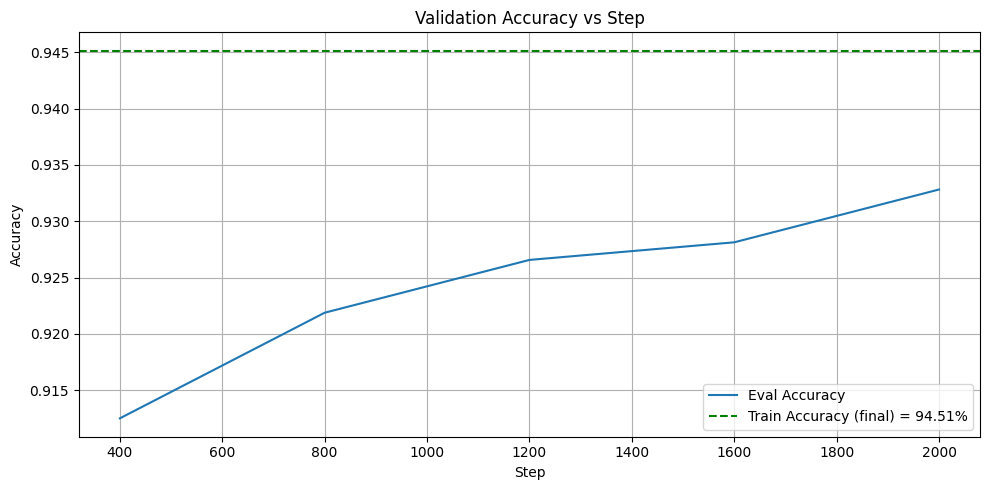

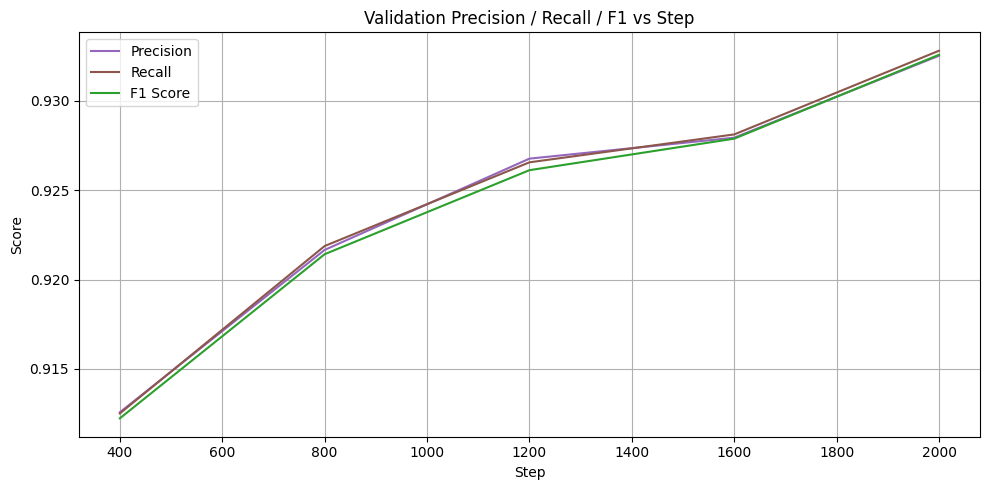

In [ ]:
import matplotlib.pyplot as plt

# Extract log history
logs = final_trainer.state.log_history

# --- Train & Eval Loss ---
train_entries = [x for x in logs if "loss" in x and "eval_loss" not in x]
train_steps = [e["step"] for e in train_entries]
train_loss = [e["loss"] for e in train_entries]

eval_entries = [x for x in logs if "eval_loss" in x]
eval_steps = [e["step"] for e in eval_entries]
eval_loss = [e["eval_loss"] for e in eval_entries]

# --- Evaluation Accuracy ---
eval_acc_entries = [x for x in logs if "eval_accuracy" in x]
eval_acc_steps = [e["step"] for e in eval_acc_entries]
eval_acc_vals = [e["eval_accuracy"] for e in eval_acc_entries]

# --- Precision, Recall, F1 ---
prec_entries = [x for x in logs if "eval_precision" in x]
recall_entries = [x for x in logs if "eval_recall" in x]
f1_entries = [x for x in logs if "eval_f1" in x]

prec_steps = [e["step"] for e in prec_entries]
recall_steps = [e["step"] for e in recall_entries]
f1_steps = [e["step"] for e in f1_entries]

precision = [e["eval_precision"] for e in prec_entries]
recall = [e["eval_recall"] for e in recall_entries]
f1_score = [e["eval_f1"] for e in f1_entries]

# --- Optional: Train Accuracy (constant line from final metric) ---
try:
    train_metrics, _ = evaluate_model(final_trainer.model, train_set, labelled=True, batch_size=32, data_collator=datacollator)
    train_acc_final = train_metrics["accuracy"]
except:
    train_acc_final = None

# === PLOTTING ===

# Plot 1 — Loss: Train vs Eval
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss", color='tab:blue')
plt.plot(eval_steps, eval_loss, label="Eval Loss", color='tab:orange')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2 — Accuracy: Eval vs Optional Train
plt.figure(figsize=(10, 5))
plt.plot(eval_acc_steps, eval_acc_vals, label="Eval Accuracy", color='tab:blue')
if train_acc_final is not None:
    plt.axhline(y=train_acc_final, color='green', linestyle='--', label=f"Train Accuracy (final) = {train_acc_final:.2%}")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3 — Precision, Recall, F1
plt.figure(figsize=(10, 5))
plt.plot(prec_steps, precision, label="Precision", color='tab:purple')
plt.plot(recall_steps, recall, label="Recall", color='tab:brown')
plt.plot(f1_steps, f1_score, label="F1 Score", color='tab:green')
plt.xlabel("Step")
plt.ylabel("Score")
plt.title("Validation Precision / Recall / F1 vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
